# Generate training samples for 3d ViT

This notebook geneerate training samples (batch size = 1) for 3d ViT.
* Training and validation samples were generated.
* Samples were saved as .npy files; their file names contain the datetime information.

In [1]:
import os
import sys
import time
import h5py
import numpy as np
from glob import glob
from datetime import datetime, timedelta

# ------------------------------------------------------- #
# Turn-off warnings
import logging
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# ------------------------------------------------------- #
# Turn-off tensoflow-specific warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

# ------------------------------------------------------- #
# Import customized modules and settings
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import model_utils as mu

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def norm_precip(x):
    return np.log(0.1*x+1)

def to_precip(x):
    x[x<0] = 0
    return 10*(np.exp(x) - 1)

## Import VQ-VAE encoder

In [4]:
# Hyperparameters
filter_nums = [64, 128] # number of convolution kernels per down-/upsampling layer 
latent_dim = 4 # number of latent feature channels
activation = 'gelu' # activation function
num_embeddings = 128 #128 # number of the VQ codes

input_size = (224, 464, 1) # size of MRMS input
latent_size = (14, 29, latent_dim) # size of compressed latent features

drop_encode = True
drop_decode = True

# location for saving new weights
model_name_encoder_load = model_dir+'models/VQ_VAE_encoder_stack1_tune0'
model_name_decoder_load = model_dir+'models/VQ_VAE_decoder_stack1_tune0'

model_encoder = mu.VQ_VAE_encoder(input_size, filter_nums, latent_dim, num_embeddings, activation, drop_encode)

W_old = mu.dummy_loader(model_name_encoder_load)
model_encoder.set_weights(W_old)

## Generate training samples

* Locations: `$camp_dir/BATCH_ViT_members/`
* VQ-VAE encoder is applied

In [5]:
BATCH_dir = camp_dir+'BATCH_ViT_members_opt/'
batch_name = 'ViT_{}.npy' #.format(datetime)

LEADs = np.arange(6, 144+6, 6) # forecast lead times
N_leads = len(LEADs)

grid_shape = (N_leads, 14, 29, 4)
ccpa_shape = (224, 464)

with h5py.File(save_dir+'CCPA_domain.hdf', 'r') as h5io:
    land_mask_CCPA = h5io['land_mask_CCPA'][...]
land_mask_CCPA = np.logical_not(land_mask_CCPA)

In [6]:
year = 2021

# ------------------------------------------------------- #
# Datetime information

base = datetime(year, 1, 1)

if year % 4 == 0:
    N_days = 366
else:
    N_days = 365

date_list = [base + timedelta(days=d) for d in range(N_days)]

In [7]:
filename_ccpa = camp_dir+'CCPA/CCPA_y{}.hdf'

with h5py.File(filename_ccpa.format(year), 'r') as h5io:
    CCPA_base = h5io['CCPA'][...]
L_base = len(CCPA_base)

# forecast lead times can exceed one year
N_beyond = 10
N_total = L_base + N_beyond
with h5py.File(filename_ccpa.format(year+1), 'r') as h5io:
    CCPA_extra = h5io['CCPA'][:N_beyond, ...]

CCPA = np.concatenate((CCPA_base, CCPA_extra), axis=0)
CCPA = norm_precip(CCPA)
CCPA[:, :, land_mask_CCPA] = 0.0

In [15]:
date_list = [base + timedelta(days=day) for day in range(365)]

CCPA_true = np.empty((24, 224, 464))
GEFS_embed = np.empty((24, 31, 14, 29, 12))
CCPA_embed = np.empty(grid_shape)

In [1]:
filename_gefs = camp_dir+'GFS/{}.hdf'
filename_gefs_AVE = camp_dir+'GFS/{}_mean.hdf'
filename_gefs_STD = camp_dir+'GFS/{}_std.hdf'

for d, dt in enumerate(date_list):
    
    dt_str = datetime.strftime(dt, '%Y%m%d')
    filename_ = filename_gefs.format(dt_str)
    filename_AVE = filename_gefs_AVE.format(dt_str)
    filename_STD = filename_gefs_STD.format(dt_str)
    
    if os.path.isfile(filename_):

        with h5py.File(filename_, 'r') as h5io:
            apcp = h5io['apcp'][...]
    
        with h5py.File(filename_AVE, 'r') as h5io:
            apcp_AVE = h5io['apcp_mean'][...]
    
        with h5py.File(filename_STD, 'r') as h5io:
            apcp_STD = h5io['apcp_std'][...]

        apcp = norm_precip(apcp)
        apcp[:, :, land_mask_CCPA] = 0.0

        apcp_AVE = norm_precip(apcp_AVE)
        apcp_AVE[:, land_mask_CCPA] = 0.0

        apcp_STD = norm_precip(apcp_STD)
        apcp_STD[:, land_mask_CCPA] = 0.0

        GEFS_embed[...] = np.nan
        CCPA_embed[...] = np.nan
        
        for ilead, lead in enumerate(LEADs):
            d_ = lead // 24
            day = d + d_
            ind_hour = lead % 24
            ind_hour = int(ind_hour/6)

            CCPA_true[ilead, ...] = CCPA[day, ind_hour, ...]
            ccpa_input = CCPA[day, ind_hour, ...][None, ..., None]
            
            gefs_ave_input = apcp_AVE[ilead, ...][None, ..., None]
            gefs_std_input = apcp_STD[ilead, ...][None, ..., None]
            
            CCPA_embed[ilead, ...] = model_encoder.predict(ccpa_input, verbose=0)[0, ...]
            GEFS_embed[ilead, ..., 4:8] = model_encoder.predict(gefs_ave_input, verbose=0)
            GEFS_embed[ilead, ..., 8:12] = model_encoder.predict(gefs_std_input, verbose=0)
            
            gefs_input = apcp[ilead, ...][..., None]
            GEFS_embed[ilead, ..., 0:4] = model_encoder.predict(gefs_input, verbose=0)
    
        if np.sum(np.isnan(CCPA_embed)) + np.sum(np.isnan(GEFS_embed)) == 0:        
            data_save = {}
            data_save['GEFS_raw'] = to_precip(apcp)
            data_save['CCPA_true'] = CCPA_true
            data_save['CCPA_embed'] = CCPA_embed
            data_save['GEFS_embed'] = GEFS_embed
            save_name_ = BATCH_dir+batch_name.format(dt_str)
            print(save_name_)
            np.save(save_name_, data_save)
        else:
            raise

### Check batch quality

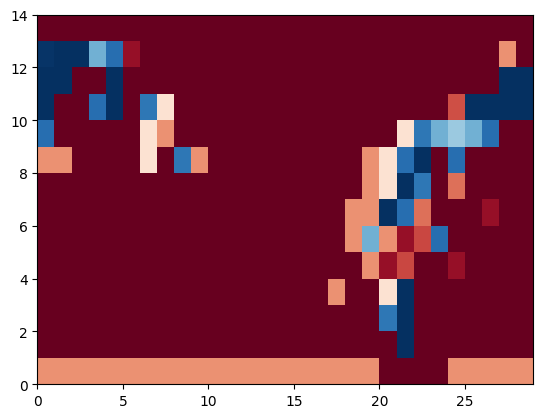

In [36]:
plt.pcolormesh(data_save['GEFS_embed'][-5, 0, ..., 0], vmin=-0.1, vmax=0.1, cmap=plt.cm.RdBu_r)